In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import emcee
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [4]:
df=pd.read_csv("NED26.05.1-D-12.1.0-20160501.csv",skiprows=12)
df=df[np.isnan(df['redshift (z)'])]
df=df[df['D (Mpc)']<500]
df=df[np.isfinite(df.err)]
df=df[df['D (Mpc)']>35]
for i in np.unique(df.Method):
    df1=df[df.Method==i]
    print i,df1.shape
listcut=np.unique(df1['Galaxy ID'])

AGN time lag (24, 15)
Black Hole (12, 15)
CMD (3, 15)
Cepheids (4, 15)
D-Sigma (815, 15)
Dwarf Galaxy Diameter (6, 15)
FP (11038, 15)
Faber-Jackson (527, 15)
GCLF (36, 15)
GeV TeV ratio (3, 15)
H I + optical distribution (1, 15)
HII region diameter (1, 15)
IRAS (2089, 15)
Maser (6, 15)
Ring Diameter (71, 15)
SBF (236, 15)
SGRB (5, 15)
SNII optical (319, 15)
SNII radio (6, 15)
SNIa (1988, 15)
SZ effect (5, 15)
Sosies (129, 15)
Tertiary (92, 15)
Tully est (264, 15)
Tully-Fisher (36718, 15)


In [59]:
# Likelihood
def lnlike(theta, x, y,yerr,ydel):
    m ,b,n,f,o,g = theta
    model = m * x +b+n*ydel*x+f*ydel+o*ydel**2+g*x**2 # model equation
    inv_sigma2 = 1.0/((yerr)**2) # weighted by the GMM-fitted sigma
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2))) 
# Priors
def lnprior(theta):
    m, b,n,f,o,g = theta
    if -2 < m < 2 and -20 < b < 20 and  -1 < n < 1 and -10 < f < 10 and -10 < o < 10 and -10 < g < 10:
        return 0.0
    return -np.inf
# Posterior probability
def lnprob(theta, x, y,yerr,ydel):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y,yerr,ydel)

In [16]:
%%time
ncutoff=12
listcho=[]
for i in listcut:
    dfilter=(df1['Galaxy ID']==i)
    if(len(df1[dfilter])>ncutoff): # Select galaxies which have more than n measurements
        listcho.append(i)


CPU times: user 16.1 s, sys: 0 ns, total: 16.1 s
Wall time: 16.1 s


In [ ]:
dtest=[]

In [ ]:
%%time
nbins=1 # resolution for the generated distributions
nreal=100

for lk in range(100):
    errlist=np.zeros((len(listcho),4))
    k=0
    for i in listcho:
        dfilter=(df1['Galaxy ID']==i)
        glen=dfilter.sum()
        boolar=np.ones(glen).astype(bool)
        boolar[np.random.random_integers(glen)-1]=False
        dummy=df1[dfilter][boolar]
        booterr=np.zeros(nreal)
        bootmean=np.zeros(nreal)
        for l in range(nreal):
            data=np.array([])
            for i in dummy.D:
                otherfilter=(dummy.D==i)
                # generate distance distribution for each distance modulus/ distance modulus error measurement
                AA=10**(np.random.normal(dummy['m-M'][otherfilter],dummy['err'][otherfilter],nbins)/5.+1)
                data=np.hstack((data,AA))            
            booterr[l]=np.percentile(data, 84)/1e6-np.percentile(data, 16)/1e6
            bootmean[l]=np.mean(data)
        dumerr=disterr[dfilter]
    #        print np.mean(booterr),(np.percentile(booterr, 84)-np.percentile(booterr, 16)),dumerr.mean(),np.linalg.norm(dumerr/dummy['D (Mpc)'])*(dummy['D (Mpc)'].mean())

        em=len(df1[dfilter][boolar])
        # Distances in Mpc
        errlist[k,0]=em # Number of measurements for each galaxy
        errlist[k,1]=np.mean(booterr) # Percentiles of the combined distance distributions (50, 84, 16):
        errlist[k,2]=(np.percentile(booterr, 84)-np.percentile(booterr, 16))
        errlist[k,3]=np.mean(bootmean)/1e6 # rms error (D)
        k+=1
    x=errlist[(errlist[:,0]!=0)][:,3]
    y=errlist[(errlist[:,0]!=0)][:,1]
    yerr=errlist[(errlist[:,0]!=0)][:,2]
    ydel=yerr
    # discrepancy test
    # This block uses the emcee MCMC sampler to estimate the posterior probability
    # 1. Guess the starting places for the walkers from a maximum likelihood fit
    nll = lambda *args: -lnlike(*args)
    argum=(x, y,yerr,ydel)
    result = op.minimize(nll, [1,1,1,1,1,1], args=argum)
    m_ml, b_ml,n_ml,f_ml,o_ml,g_ml= result["x"]
    ndim, nwalkers = len(result["x"]), 100
    pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=argum) 
    # 2. Let the walkers walk 1000 steps (10000 will do the trick as well)
    sampler.run_mcmc(pos, 1000);
    # Here we remove the burn-in steps, which we estimate to be around 100
    # This can be estimated by calculating the autocorrelation time (see below)
    samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) 
    discobs=[]
    discsim=[]
    nrealiz=10000
    for m,b,n,f,o,g in samples[np.random.randint(len(samples), size=nrealiz)]: # draw Theta_i from posterior predictive, do this 5000 times
        AAA=samples[np.random.randint(len(samples), size=len(x))]
        y_sim=AAA[:,0]*x+AAA[:,1]+AAA[:,2]*ydel*x+AAA[:,3]*ydel+AAA[:,4]*ydel**2+AAA[:,5]*x**2 # create a synthetic dataset
        yexp=m*x+b+n*ydel*x+f*ydel+o*ydel**2+g*x**2 # calculate expected values from Theta_i
    # Calculate discrepancies using the Freeman-Tukey statistic
        discobs.append(((np.sqrt(y)-np.sqrt(yexp))**2).sum())
        discsim.append(((np.sqrt(y_sim)-np.sqrt(yexp))**2).sum())
    discobs=np.asarray(discobs)
    discsim=np.asarray(discsim)
    dtest.append((discobs<discsim).sum()*1./len(discobs))

In [76]:
dtest

[0.0385,
 0.034500000000000003,
 0.068900000000000003,
 0.0246,
 0.14180000000000001,
 0.11210000000000001,
 0.046699999999999998,
 0.048500000000000001,
 0.053800000000000001,
 0.051200000000000002]

In [77]:
this=np.asarray(dtest)

(array([ 2.,  2.,  3.,  1.,  0.,  0.,  0.,  1.,  0.,  1.]),
 array([ 0.0246 ,  0.03632,  0.04804,  0.05976,  0.07148,  0.0832 ,
         0.09492,  0.10664,  0.11836,  0.13008,  0.1418 ]),
 <a list of 10 Patch objects>)

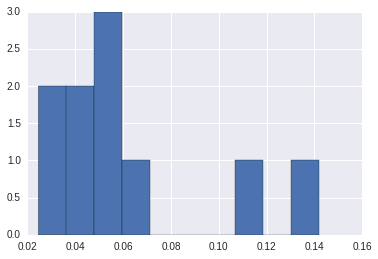

In [78]:
plt.hist(this)

In [81]:
np.unique(errlist[:,0])

array([ 12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.])